# Data exploration

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import glob, os
import time
import PIL
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
train = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv")
train.tail()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
3142,9951,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3143,9960,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3144,9961,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3145,9980,1,0,1,0,1,0,0,1,0,0,0,0,1,1
3146,9983,1,0,1,0,1,0,0,1,0,0,0,0,1,1


In [3]:
train_series_meta = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv")
print("Number of unique patients in train dataset: ", len(train_series_meta['patient_id'].unique()))
print("Number of samples in train dataset: ", len(train_series_meta['patient_id']))
train_series_meta.head(100)

Number of unique patients in train dataset:  3147
Number of samples in train dataset:  4711


,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0
...,...,...,...,...
95,11312,51300,179.00,0
96,11313,48992,297.00,0
97,11335,24276,111.00,0
98,11335,39434,216.00,0


So there is 3147 unique patients and 4711 scans taken from them.

In [4]:
image_level_labels = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv")
unique_injuries = image_level_labels['injury_name'].unique()
print("Unique injuries: ", unique_injuries)
image_level_labels.head(1000)

Unique injuries:  ['Active_Extravasation' 'Bowel']


,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation
...,...,...,...,...
995,12332,15276,60,Bowel
996,12332,15276,61,Bowel
997,12332,15276,62,Bowel
998,12332,15276,63,Bowel


# Segment organs

## Get already segmented

In [5]:
!pip install dicomsdl

import dicomsdl as dicoml
import nibabel as nib
#from joblib import Parallel, delayed
import glob
import time
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.3 MB/s eta 0:00:0000:010:01


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
# convenience directory variables
ROOT_DIR = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
TRAIN_DIR = f'{ROOT_DIR}/train_images'
SEG_DIR = f'{ROOT_DIR}/segmentations'

In [8]:
def create_3D_scans(folder, downsample_rate=1, voi_lut=True): 
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    filenames = [str(filename) + '.dcm' for filename in filenames]
        
    volume = []
    for filename in filenames:
        filepath = os.path.join(folder, filename)
        dataset = dicoml.open(filepath)
        img = dataset.pixelData()

        if voi_lut:
            # Load only the variables we need
            center = dataset["WindowCenter"]
            width = dataset["WindowWidth"]
            bits_stored = dataset["BitsStored"]
            voi_lut_function = dataset["VOILUTFunction"]

            # For sigmoid it's a list, otherwise a single value
            if isinstance(center, list):
                center = center[0]
            if isinstance(width, list):
                width = width[0]

            # Set y_min, max & range
            y_min = 0
            y_max = float(2**bits_stored - 1)
            y_range = y_max

            # Function with default LINEAR (so for Nan, it will use linear)
            if voi_lut_function == "SIGMOID":
                img = y_range / (1 + np.exp(-4 * (img - center) / width)) + y_min
            else:
                # Checks width for < 1 (in our case not necessary, always >= 750)
                center -= 0.5
                width -= 1

                below = img <= (center - width / 2)
                above = img > (center + width / 2)
                between = np.logical_and(~below, ~above)

                img[below] = y_min
                img[above] = y_max
                if between.any():
                    img[between] = (
                        ((img[between] - center) / width + 0.5) * y_range + y_min
                    )

        if dataset["PhotometricInterpretation"] == "MONOCHROME1":
            img = np.amax(img) - img
            
        if np.max(img) != 0:
            img = img / np.max(img)
        img=(img * 255).astype(np.uint8)
    
        volume.append(img)
    
    volume = np.stack(volume, axis=0)
    return volume


def create_3D_segmentations(filepath, downsample_rate=1):
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [1, 0, 2])
    img = np.rot90(img, 1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [1, 0, 2])
    img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    return img

In [9]:
def get_filepath_from_series_id(series_id:int, series_meta:pd.DataFrame):
    segmention_sample = series_id
    segmented_case_ids = series_meta[series_meta.series_id==segmention_sample].values[0][:2].astype(int)
    img_dir = f'{TRAIN_DIR}/{segmented_case_ids[0]}/{segmented_case_ids[1]}'
    mask_path = f'{SEG_DIR}/{segmention_sample}.nii'
    if os.path.isfile(mask_path):
        return img_dir, mask_path
    return img_dir, None

def dcm_info(series_id, label_dict, series_meta):
    
    crop_sizes = {'liver': [9999,9999,0,0],
                  'spleen':[9999,9999,0,0],
                  'kidney_left': [9999,9999,0,0],
                  'kidney_right': [9999,9999,0,0]
                 }
    
    odata = {'series_id': series_id,
             'images': 0, # len of images
             'image_size': (0,0),
             # information about first and last apperance of organ in ct images
             'liver_frames': [],
             'spleen_frames': [],
             'kidney_left_frames': [],
             'kidney_right_frames': [],
             # all boxes boxes
             'liver_boxes': [],
             'spleen_boxes': [],
             'kidney_left_boxes': [],
             'kidney_right_boxes': [],
             # box that contains all boxes
             'liver_abox': [],
             'spleen_abox': [],
             'kidney_left_abox': [],
             'kidney_right_abox': []
    }
    
    img_dir, mask_path = get_filepath_from_series_id(series_id, series_meta)
    cor = create_3D_scans(img_dir, downsample_rate=1)
    odata['images'] = cor.shape[0]
    odata['image_size'] = (cor.shape[1], cor.shape[2])
    
    mask = None
    if mask_path:
        mask = create_3D_segmentations(mask_path, downsample_rate=1)
    
    for i in range(cor.shape[0]):
        if not np.any(mask[i,:,:]):
            continue
        for key, value in label_dict.items():
            o_mask = np.select([np.isin(mask[i,:,:], value)], [1.0], [0.0])
            if not np.any(o_mask):
                continue
            # append organ frames
            odata[key+'_frames'].append(i)

            segment = cor[i,:,:]*o_mask
            
            # get box
            pos = np.nonzero(o_mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            bbox = [xmin, ymin, xmax, ymax]
                            
            odata[key+'_boxes'].append(bbox)

    for key, value in crop_sizes.items():
        if odata[key+'_boxes']:
            odata[key+'_boxes'] = np.array(odata[key+'_boxes'])
            odata[key+'_abox'] = [np.min(odata[key+'_boxes'][:,0]), 
                                  np.min(odata[key+'_boxes'][:,1]), 
                                  np.max(odata[key+'_boxes'][:,2]), 
                                  np.max(odata[key+'_boxes'][:,3])]
        
    return cor, odata

In [10]:
# labels 
label_dict = {'liver': [1],
              'spleen': [2],
              'kidney_left': [3],
              'kidney_right': [4],
              #'bowel': [5]
             }

# get samples with segments
os.chdir("/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations")
segmented_samples = [int(file.replace('.nii', '')) for file in glob.glob("*.nii")]

# study and series id dataframe
series_meta = pd.read_csv(f'{ROOT_DIR}/train_series_meta.csv')
train = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv")

In [11]:
images_info = []
for sample in tqdm(segmented_samples):
    _, odata = dcm_info(sample, label_dict, series_meta)
    images_info.append(odata)

im_info = pd.DataFrame(images_info)

  0%|          | 0/206 [00:00<?, ?it/s]

In [14]:
im_info.head(3)

,series_id,images,image_size,liver_frames,spleen_frames,kidney_left_frames,kidney_right_frames,liver_boxes,spleen_boxes,kidney_left_boxes,kidney_right_boxes,liver_abox,spleen_abox,kidney_left_abox,kidney_right_abox
0,39222,208,"(512, 512)","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3...","[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...","[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 6...","[[194, 190, 209, 204], [183, 170, 226, 221], [...","[[357, 286, 371, 296], [337, 279, 379, 306], [...","[[316, 298, 343, 328], [312, 291, 349, 330], [...","[[196, 283, 213, 303], [190, 278, 216, 308], [...","[109, 108, 341, 329]","[306, 228, 420, 353]","[309, 230, 382, 330]","[150, 223, 221, 317]"
1,52961,293,"(512, 512)","[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...","[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 8...","[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 9...","[[177, 233, 203, 265], [170, 227, 229, 271], [...","[[342, 330, 362, 336], [335, 326, 368, 338], [...","[[299, 293, 311, 312], [295, 289, 315, 316], [...","[[213, 298, 222, 312], [208, 293, 224, 318], [...","[121, 175, 352, 344]","[319, 295, 405, 343]","[285, 257, 364, 330]","[153, 236, 228, 328]"
2,7334,152,"(512, 512)","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...","[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...","[[164, 243, 198, 280], [156, 233, 211, 288], [...","[[344, 325, 387, 345], [338, 324, 398, 354], [...","[[310, 345, 329, 370], [308, 340, 335, 375], [...","[[200, 344, 213, 359], [185, 327, 219, 367], [...","[108, 190, 338, 389]","[330, 282, 431, 392]","[300, 324, 385, 390]","[135, 283, 226, 381]"


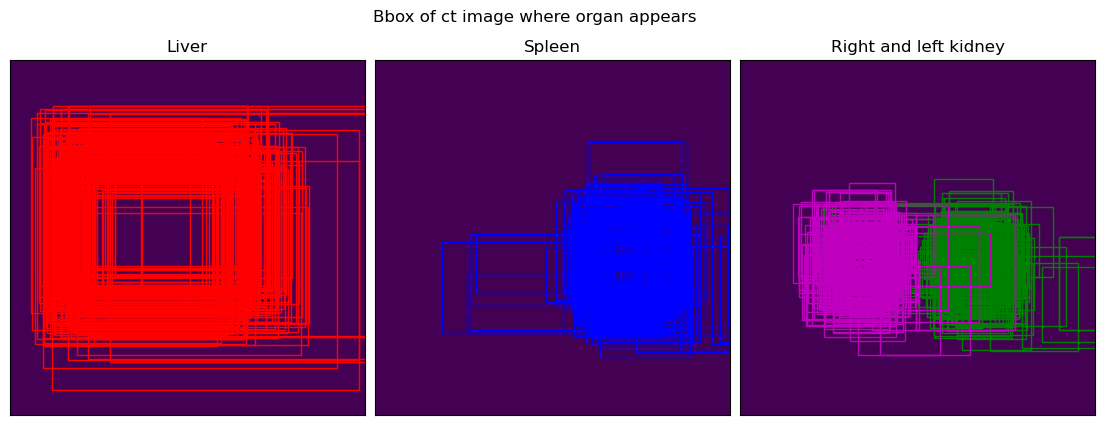

In [45]:
import matplotlib.patches as patches
#abox is a box that contains all other boxes
liver_sizes = im_info['liver_abox']
spleen_sizes = im_info['spleen_abox']
left_k_sizes = im_info['kidney_left_abox']
right_k_sizes = im_info['kidney_right_abox']

fig, axes = plt.subplots(1,3,figsize=(14, 8))
ax = axes.ravel()

l_widths = []
l_heights = []
ax[0].imshow(np.zeros((514,514)))
for  box in liver_sizes:
    if box:
        ax[0].add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none', visible=True))
        l_widths.append(box[2]-box[0])
        l_heights.append(box[3]-box[1])
ax[0].set_title('Liver')

s_widths = []
s_heights = []
ax[1].imshow(np.zeros((514,514)))
for  box in spleen_sizes:
    if box:
        ax[1].add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='b', facecolor='none', visible=True))
        s_widths.append(box[2]-box[0])
        s_heights.append(box[3]-box[1])
ax[1].set_title('Spleen')

lk_widths = []
lk_heights = []
ax[2].imshow(np.zeros((514,514)))
for  box in left_k_sizes:
    if box:
        ax[2].add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='g', facecolor='none', visible=True))
        s_widths.append(box[2]-box[0])
        s_heights.append(box[3]-box[1])

rk_widths = []
rk_heights = []
ax[2].imshow(np.zeros((514,514)))
for  box in right_k_sizes:
    if box:
        ax[2].add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='m', facecolor='none', visible=True))
        s_widths.append(box[2]-box[0])
        s_heights.append(box[3]-box[1])
ax[2].set_title('Right and left kidney')

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.xaxis.set_tick_params(labelbottom=False)
    axis.yaxis.set_tick_params(labelleft=False)
    
plt.subplots_adjust(wspace=0.03, hspace=0)
plt.suptitle("Bbox of ct image where organ appears", y=0.78)
plt.show()

In [18]:
for size in im_info['image_size']:
    if size != (512,512):
        print(size)

(512, 640)
(512, 882)
(512, 544)
(512, 882)
(512, 702)
(512, 747)
(512, 750)
(512, 747)
(512, 737)


That's why some of these boxes seem out of touch. As we can see not all of them are equal to 512 in width dimention.

In [46]:
cor, odata = dcm_info(397, label_dict,series_meta)

In [61]:
import matplotlib.animation as animation
import matplotlib.patches as patches
from IPython.display import HTML

#box
#                +------------------+
#                |                  |
#              height               |
#                |                  |
#               (xy)---- width -----+

def set_images(i):
    try:
        plt.title(str(i))
        im.set_array(ima[i,:,:])
        if i in odata['liver_frames']:
            box_ind = odata['liver_frames'].index(i)
            box = odata['liver_boxes'][box_ind]
            ax.patches[1].remove()
            ax.add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none', visible=True))
        else:
            ax.patches[1].remove()
            ax.add_patch(patches.Rectangle((0, 1), 5, 5, linewidth=1, edgecolor='r', facecolor='none', visible=False))
        
        
    except Exception as error:
        print(i)
        print(error)
        
    
ima = cor
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the first frame and keep the plot object for later
im = ax.imshow(ima[0,:,:], cmap='gray', vmin=0, vmax = 255, animated=True)
box = odata['liver_abox']
ax.add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none', visible=True))
ax.add_patch(patches.Rectangle((0, 1), 5, 5, linewidth=1, edgecolor='r', facecolor='none', visible=False))

#Create the animation
amn = animation.FuncAnimation(fig, lambda i : set_images(i), frames=range(cor.shape[0]), repeat=True, repeat_delay=50000)
# Demonstrate the animation
example = HTML(amn.to_html5_video())
plt.close()

In [62]:
example

## previous version

In [ ]:
# labels 
label_dict = {'liver': [1],
              'spleen': [2],
              'kidney_left': [3],
              'kidney_right': [4],
              'bowel': [5]
             }

# get samples with segments
os.chdir("/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations")
segmented_samples = [int(file.replace('.nii', '')) for file in glob.glob("*.nii")]

# study and series id dataframe
series_meta = pd.read_csv(f'{ROOT_DIR}/train_series_meta.csv')
train = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv")

In [ ]:
# amass information from tables
full_pd = series_meta
full_pd['segmented'] = full_pd['series_id'].isin(segmented_samples)
full_pd = full_pd.merge(train, on=['patient_id'], how='left')

In [ ]:
full_segmented = full_pd[full_pd['segmented']==True]

In [ ]:
# take one samplfe of healthy high and low livers
liver_healthy = full_segmented[full_segmented['liver_healthy']==1]['series_id'].iloc[0]
liver_high = full_segmented[full_segmented['liver_high']==1]['series_id'].iloc[0]
liver_low = full_segmented[full_segmented['liver_low']==1]['series_id'].iloc[0]

In [ ]:
print(len(odata['liver_boxes']))

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

def set_images(i):
    try:
        plt.title(str(i))
        im.set_array(ima[i,:,:])
    except Exception as error:
        print(error)
        
    
ima = organs3['liver']
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the first frame and keep the plot object for later
im = ax.imshow(ima[0,:,:], cmap='gray', vmin=0, vmax = 255, animated=True)

#Create the animation
amn = animation.FuncAnimation(fig, lambda i : set_images(i), frames=ima.shape[0], repeat=True, repeat_delay=50000)

# Demonstrate the animation
HTML(amn.to_html5_video())

In [ ]:
def get_filepath_from_series_id(series_id:int, series_meta:pd.DataFrame):
    segmention_sample = series_id
    segmented_case_ids = series_meta[series_meta.series_id==segmention_sample].values[0][:2].astype(int)
    img_dir = f'{TRAIN_DIR}/{segmented_case_ids[0]}/{segmented_case_ids[1]}'
    mask_path = f'{SEG_DIR}/{segmention_sample}.nii'
    if os.path.isfile(mask_path):
        return img_dir, mask_path
    return img_dir, None

def preprocess_dcm(series_id, label_dict, series_meta,
                   split_organs =True, allow_bowel = False, 
                   cropp_organ = True, concat_kidneys = True):
    
    organs = {'liver': [],
              'spleen':[],
              'kidney_left': [],
              'kidney_right': [],
              'bowel': []}
    
    crop_sizes = {'liver': [9999,9999,0,0],
                  'spleen':[9999,9999,0,0],
                  'kidney_left': [9999,9999,0,0],
                  'kidney_right': [9999,9999,0,0],
                  'bowel': [9999,9999,0,0]}
    
    
    img_dir, mask_path = get_filepath_from_series_id(series_id, series_meta)
    cor = create_3D_scans(img_dir, downsample_rate=1)
    mask = None
    if mask_path:
        mask = create_3D_segmentations(mask_path, downsample_rate=1)
    
    # Organ splitting
    if split_organs and mask_path:
        for i in range(cor.shape[0]):
            if not allow_bowel:
                mask = np.select([mask[i,:,:] == 5], [0], mask[i,:,:])
            if not np.any(mask[i,:,:]):
                continue
            for key, value in label_dict.items():
                o_mask = np.select([np.isin(mask[i,:,:], value)], [1.0], [0.0])

                if not np.any(o_mask):
                    if concat_kidneys and key in ['kidney_left', 'kidney_right']:
                        if key == 'kidney_left':
                            if not np.any(np.select([np.isin(mask[i,:,:], label_dict['kidney_right'])], [1.0], [0.0])):
                                continue
                        if key == 'kidney_right':
                            if not np.any(np.select([np.isin(mask[i,:,:], label_dict['kidney_left'])], [1.0], [0.0])):
                                continue
                    else:
                        continue

                segment = cor[i,:,:]*o_mask
                organs[key].append(segment)

                if cropp_organ:
                    true_points = np.argwhere(segment)
                    if np.any(true_points):
                        for j in range(2):
                            tp = true_points.min(axis=0)[j]
                            if tp < crop_sizes[key][j]:
                                 crop_sizes[key][j] = tp
                        for j in range(2,4):
                            tp = true_points.max(axis=0)[j-2]
                            if tp > crop_sizes[key][j]:
                                 crop_sizes[key][j] = tp
                                
        if cropp_organ and concat_kidneys:
            #fix height of both kidneys
            up_bound = np.min([crop_sizes['kidney_left'][0], crop_sizes['kidney_right'][0]])
            down_bound = np.max([crop_sizes['kidney_left'][2], crop_sizes['kidney_right'][2]])
            crop_sizes['kidney_left'][0] = up_bound
            crop_sizes['kidney_right'][0] = up_bound
            crop_sizes['kidney_left'][2] = down_bound
            crop_sizes['kidney_right'][2] = down_bound
                

        for key, value in organs.items():
            if cropp_organ:
                organs[key] = np.stack(organs[key], axis = 0)[:,crop_sizes[key][0]:crop_sizes[key][2], crop_sizes[key][1]:crop_sizes[key][3]]
            else:
                organs[key] = np.stack(organs[key], axis = 0)

        if concat_kidneys:
            organs['kidneys'] = np.concatenate((organs['kidney_left'], organs['kidney_right']), axis=2)
        
        return cor, mask, organs
    
    return cor, mask